In [1]:
import csv
import random
import pandas as pd
from tqdm import tqdm
from itertools import islice
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer

SEED = 1337
random.seed(SEED)

INFO 03-14 21:25:48 __init__.py:190] Automatically detected platform cuda.


In [2]:
df = pd.read_csv("../../data/data_raw/nyt-comments-2020.csv", usecols=["commentBody", "articleID"])
df.head()

,commentBody,articleID
0,Here is something I think is fraudulent that v...,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...
1,@magicisnotreal I have used my VA loan option...,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...
2,@magi\n\nWhy would someone take out a VA loan ...,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...
3,@JD\nOut here in the Alabama of the PNW they w...,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...
4,@magicisnotreal just a guess but I doubt that...,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...


In [3]:
df_articles = pd.read_csv("../../data/data_raw/nyt-articles-2020.csv", usecols=["abstract", "uniqueID"])
df_articles.head()

,abstract,uniqueID
0,Congress could do much more to protect America...,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...
1,Christina Iverson and Jeff Chen ring in the Ne...,nyt://article/9edddb54-0aa3-5835-a833-d311a76f...
2,"All year long, Earth passes through streams of...",nyt://article/04bc90f0-b20b-511c-b5bb-3ce13194...
3,"Never miss an eclipse, a meteor shower, a rock...",nyt://interactive/5b58d876-9351-50af-9b41-a312...
4,A year full of highs and lows in space just en...,nyt://article/bd8647b3-8ec6-50aa-95cf-2b81ed12...


In [4]:
df = df.join(df_articles.set_index("uniqueID"), on="articleID")
df.head()

,commentBody,articleID,abstract
0,Here is something I think is fraudulent that v...,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...,Congress could do much more to protect America...
1,@magicisnotreal I have used my VA loan option...,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...,Congress could do much more to protect America...
2,@magi\n\nWhy would someone take out a VA loan ...,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...,Congress could do much more to protect America...
3,@JD\nOut here in the Alabama of the PNW they w...,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...,Congress could do much more to protect America...
4,@magicisnotreal just a guess but I doubt that...,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...,Congress could do much more to protect America...


In [5]:
df.isna().sum()

commentBody      1
articleID        0
abstract       360
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
df["length_comment"] = df["commentBody"].str.len()
df["length_abstract"] = df["abstract"].str.len()

In [8]:
df = df[(df["length_comment"] >= 50) & (df["length_abstract"] >= 50)]

In [9]:
df.duplicated(subset="commentBody").sum()

np.int64(12081)

In [10]:
df.drop_duplicates(subset="commentBody", inplace=True)
df.reset_index(drop=True, inplace=True)

In [11]:
len(df)

4223213

In [12]:
def batchify(iterable, batch_size):
    """Splits an iterable into smaller batches."""
    iterable = iter(iterable)
    while batch := list(islice(iterable, batch_size)):
        yield batch

def save_to_csv(path, prompts, responses, temperature, top_p, top_k):
    """Saves prompts, responses and sampling parameters to a CSV file."""
    with open(path, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        for prompt, response in zip(prompts, responses):
            writer.writerow([prompt, response, temperature, top_p, top_k])

def generate_responses(model, prompts, sampling_params):
    """Generate a batch of outputs using vLLM with customizable sampling parameters."""
    outputs = model.chat(prompts, sampling_params=sampling_params, use_tqdm=False)
    
    return [sample.outputs[0].text.replace('"', '') for sample in outputs]

In [13]:
BASE_PROMPT = [{"role": "system", "content": "You are a helpful asistant for writing comments based on article abstracts and sample comments. Based on provided article abstract and a sample comment generate similar comment related to the article. MAKE SURE TO REPLAY ONLY WITH THE COMMENT."},
                {"role": "user", "content": "Abstract: \n {abstract} \n  Comment: \n {comment}."},
                {"role": "assistant", "content": "Similar comment: \n"}]

In [14]:
prompts = [
    [
        BASE_PROMPT[0],  # The system message
        {"role": "user", "content": BASE_PROMPT[1]["content"].format(abstract=abstract, comment=comment)},  # Formatted user message
        BASE_PROMPT[2]  # The assistant message
    ]
    for abstract, comment in df[["abstract", "commentBody"]].values
]

In [15]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")

In [16]:
lens = []
batch_size = 256
for prompts_batch in tqdm(batchify(prompts, batch_size), total=len(prompts) // batch_size):
    tokens = tokenizer.apply_chat_template(prompts_batch)
    lens.extend([len(token) for token in tokens])

  1%|          | 154/16496 [00:18<38:50,  7.01it/s]

16497it [34:00,  8.09it/s]                             


In [17]:
too_large = [i for i, l in enumerate(lens) if l > 32_768]
too_large

[]

In [18]:
df.drop(columns=["articleID", "abstract"], inplace=True)
df.to_csv("../../data/data_human/nyt_comments.csv", index=False)

In [20]:
from nltk.tokenize import word_tokenize, sent_tokenize
df['word_count'] = df['commentBody'].apply(lambda x: len(word_tokenize(x)))
df['sentence_count'] = df['commentBody'].apply(lambda x: len(sent_tokenize(x)))

In [21]:
import numpy as np
import matplotlib.ticker as ticker

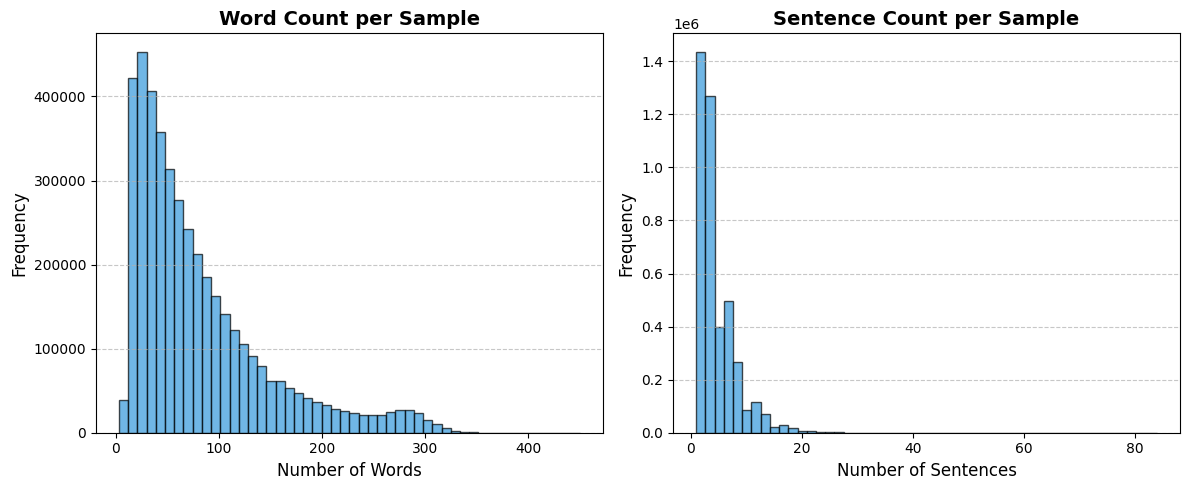

In [22]:
import matplotlib.pyplot as plt
# word_bins = np.logspace(np.log10(1), np.log10(df['word_count'].max()), 50)
# sentence_bins = np.logspace(np.log10(1), np.log10(df['sentence_count'].max()), 50)

# Plot histograms using Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

# Word count histogram
axes[0].hist(df['word_count'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
# axes[0].set_xscale('log')  # Logarithmic scale for x-axis
axes[0].set_title('Word Count per Sample', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Words', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].tick_params(axis='both', which='major', labelsize=10)
axes[0].tick_params(axis='both', which='minor', labelsize=8)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Sentence count histogram
axes[1].hist(df['sentence_count'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
# axes[1].set_xscale('log')  # Logarithmic scale for x-axis
axes[1].set_title('Sentence Count per Sample', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Sentences', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=10)
axes[1].tick_params(axis='both', which='minor', labelsize=8)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [9]:
sampling_params = [
    SamplingParams(temperature=0.0, top_p=1.0, top_k=-1, max_tokens=40_000, seed=SEED),  # Pure Greedy (fully deterministic)
    SamplingParams(temperature=0.2, top_p=1.0, top_k=-1, max_tokens=40_000, seed=SEED),  # Highly Deterministic
    SamplingParams(temperature=0.5, top_p=0.95, top_k=100, max_tokens=40_000, seed=SEED), # Mildly Deterministic but Flexible
    SamplingParams(temperature=0.7, top_p=0.9, top_k=50, max_tokens=40_000, seed=SEED),  # Balanced and Natural
    SamplingParams(temperature=0.9, top_p=0.8, top_k=40, max_tokens=40_000, seed=SEED),  # Slightly More Diverse but Coherent
    SamplingParams(temperature=1.0, top_p=0.95, top_k=30, max_tokens=40_000, seed=SEED), # Default Creative Mode
    SamplingParams(temperature=1.2, top_p=0.7, top_k=20, max_tokens=40_000, seed=SEED),  # Highly Creative
]

In [10]:
llms = ["meta-llama/Llama-3.2-1B-Instruct"]
batch_size = 8
base_path = "../../data/data_ai/nyt_comments/nyt-comments_"

In [11]:
for llm in llms:
    model = LLM(model=llm, dtype="half", max_model_len = 10_000)
    csv_path = f"{base_path}{llm.split('/')[-1]}.csv"


    # init csv file
    with open(csv_path, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["prompt", "response", "temperature", "top_p", "top_k"])

    cnt = 0
    for prompts_batch in tqdm(batchify(prompts, batch_size), total=len(prompts) // batch_size):
        params = random.choice(sampling_params)
        responses = generate_responses(model, prompts_batch, params)
        save_to_csv(csv_path, prompts_batch, responses, params.temperature, params.top_p, params.top_k)
        cnt += 1
        if cnt > 2:
            break

WARNING 02-15 05:11:44 config.py:2386] Casting torch.bfloat16 to torch.float16.
INFO 02-15 05:12:05 config.py:542] This model supports multiple tasks: {'embed', 'generate', 'score', 'reward', 'classify'}. Defaulting to 'generate'.
INFO 02-15 05:12:05 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='meta-llama/Llama-3.2-1B-Instruct', speculative_config=None, tokenizer='meta-llama/Llama-3.2-1B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=10000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, c

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 02-15 05:14:19 model_runner.py:1115] Loading model weights took 2.3185 GB
INFO 02-15 05:14:32 worker.py:267] Memory profiling takes 11.18 seconds
INFO 02-15 05:14:32 worker.py:267] the current vLLM instance can use total_gpu_memory (6.00GiB) x gpu_memory_utilization (0.90) = 5.40GiB
INFO 02-15 05:14:32 worker.py:267] model weights take 2.32GiB; non_torch_memory takes 0.04GiB; PyTorch activation peak memory takes 1.21GiB; the rest of the memory reserved for KV Cache is 1.84GiB.
INFO 02-15 05:14:33 executor_base.py:110] # CUDA blocks: 3761, # CPU blocks: 8192
INFO 02-15 05:14:33 executor_base.py:115] Maximum concurrency for 10000 tokens per request: 6.02x
INFO 02-15 05:15:16 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utili

Capturing CUDA graph shapes: 100%|██████████| 35/35 [01:55<00:00,  3.30s/it]

INFO 02-15 05:17:12 model_runner.py:1562] Graph capturing finished in 116 secs, took 0.12 GiB
INFO 02-15 05:17:12 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 172.83 seconds



  0%|          | 0/623307 [00:00<?, ?it/s]

INFO 02-15 05:17:12 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


  0%|          | 2/623307 [00:17<1539:29:42,  8.89s/it]


In [ ]:
df = pd.read_csv("../../data/data_ai/nyt_comments/nyt-comments_Llama-3.2-1B-Instruct.csv")
df.head()

,prompt,response,temperature,top_p,top_k
0,"[{'role': 'system', 'content': 'You are a help...",It's essential to note that the VA home loan p...,1.2,0.7,20
1,"[{'role': 'system', 'content': 'You are a help...",@VAloanExpert I'm a huge fan of the VA loan ...,1.2,0.7,20
2,"[{'role': 'system', 'content': 'You are a help...",@expatlife23\n\nIt's not necessarily about ta...,1.2,0.7,20
3,"[{'role': 'system', 'content': 'You are a help...",I'm so frustrated with the lack of protection ...,1.2,0.7,20
4,"[{'role': 'system', 'content': 'You are a help...","@VAloanexpert, I'm glad you're doing your res...",1.2,0.7,20
